In [ ]:
# Cell A - imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import joblib
import os

# load data
df = pd.read_csv('/content/creditcard.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


Rows,cols: (91200, 31)
Class
0.0    90988
1.0      211
Name: count, dtype: int64
Fraud rate: 0.2314%


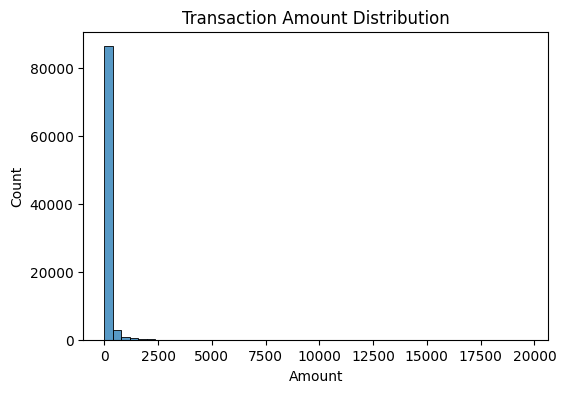

In [ ]:
# Cell B - quick EDA
print("Rows,cols:", df.shape)
print(df['Class'].value_counts())  # fraud vs non-fraud
print("Fraud rate: {:.4f}%".format(100 * df['Class'].mean()))
df['Amount'].describe()
# optional: a simple plot (won't show in headless runs)
plt.figure(figsize=(6,4))
sns.histplot(df['Amount'], bins=50)
plt.title("Transaction Amount Distribution")
plt.show()


In [ ]:
# Cell C - prepare features
# 'Time' and 'Amount' exist; V1..V28 are PCA features already
X = df.drop(columns=['Class'])
y = df['Class']

# Feature scaling for Amount (and optionally Time)
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled['Amount'] = scaler.fit_transform(X[['Amount']])
# Optionally scale Time:
X_scaled['Time'] = scaler.fit_transform(X[['Time']])


In [ ]:
# Cell D - split and SMOTE
# Identify rows where 'y' (Class) is NaN
nan_indices = y[y.isna()].index

# Drop these rows from X_scaled and y
X_scaled_cleaned = X_scaled.drop(index=nan_indices)
y_cleaned = y.drop(index=nan_indices)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_cleaned, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned)

# Apply SMOTE only on training set
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_res))

After SMOTE: [72790 72790]


In [11]:
# Cell E replacement: try LR then light RF (fast, parallel)
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Train Logistic Regression (fast)
print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000, solver='saga', class_weight='balanced', n_jobs=-1, random_state=42)
t0 = time.time()
lr.fit(X_res, y_res)   # if you used SMOTE; otherwise use X_train, y_train
print("LR trained in", round(time.time()-t0,2), "s")

# Evaluate LR
preds = lr.predict(X_test)
probs = lr.predict_proba(X_test)[:,1] if hasattr(lr, "predict_proba") else None
lr_precision = precision_score(y_test, preds)
lr_recall = recall_score(y_test, preds)
lr_f1 = f1_score(y_test, preds)
lr_roc_auc = roc_auc_score(y_test, probs) if probs is not None else None

lr_res = {
    'precision': lr_precision,
    'recall': lr_recall,
    'f1': lr_f1,
    'roc_auc': lr_roc_auc
}

print("LR Precision:", lr_precision)
print("LR Recall:", lr_recall)
print("LR F1:", lr_f1)
if probs is not None:
    print("LR ROC-AUC:", lr_roc_auc)

# Optional: Train a lighter Random Forest if you want a tree-based model
print("\nTraining lighter Random Forest (optional)...")
rf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, verbose=1, random_state=42, class_weight='balanced')
t1 = time.time()
rf.fit(X_res, y_res)
print("RF trained in", round(time.time()-t1,2), "s")

# Evaluate RF
preds_rf = rf.predict(X_test)
probs_rf = rf.predict_proba(X_test)[:,1] if hasattr(rf, "predict_proba") else None
rf_precision = precision_score(y_test, preds_rf)
rf_recall = recall_score(y_test, preds_rf)
rf_f1 = f1_score(y_test, preds_rf)
rf_roc_auc = roc_auc_score(y_test, probs_rf) if probs_rf is not None else None

rf_res = {
    'precision': rf_precision,
    'recall': rf_recall,
    'f1': rf_f1,
    'roc_auc': rf_roc_auc
}

print("RF Precision:", rf_precision)
print("RF Recall:", rf_recall)
print("RF F1:", rf_f1)
if probs_rf is not None:
    print("RF ROC-AUC:", rf_roc_auc)

Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


LR trained in 157.54 s
LR Precision: 0.09725685785536159
LR Recall: 0.9285714285714286
LR F1: 0.17607223476297967
LR ROC-AUC: 0.9788379413750334

Training lighter Random Forest (optional)...


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


RF trained in 80.45 s
RF Precision: 0.7058823529411765
RF Recall: 0.8571428571428571
RF F1: 0.7741935483870968
RF ROC-AUC: 0.9734991809670347


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [12]:
# Cell F - choose model by desired metric (precision is often crucial in fraud)
best = rf if rf_res['precision'] >= lr_res['precision'] else lr
print("Best model:", type(best).__name__)

# Save model and scaler
os.makedirs('/content/models', exist_ok=True)
joblib.dump(best, '/content/models/fraud_model.joblib')
joblib.dump(scaler, '/content/models/scaler.joblib')
print("Saved model and scaler to /content/models/")

Best model: RandomForestClassifier
Saved model and scaler to /content/models/


In [13]:
from google.colab import files
files.download('/content/models/fraud_model.joblib')
files.download('/content/models/scaler.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>